$$
\begin{cases}
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x}
+ \frac{\partial^2 u}{\partial x^2}
+ \frac{\partial^3 u}{\partial x^3}
+ \frac{\partial^4 u}{\partial x^4}
= 0, & -30 \leq x \leq 30, \;\; 0 < t \leq T \\[3ex]
u(x, 0) = \exp(-x^2), & -30 < x < 30 \\[3ex]
u(-30, t) = u(30, t) = u_x(-30, t) = u_x(30, t) = 0, & 0 < t < T
\end{cases}
$$


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tf.random.set_seed(0)
np.random.seed(0)

In [ ]:
X_MIN, X_MAX = -30, 30
T_MIN, T_MAX = 0, 1

def u_init(x):
    return np.exp(-x**2)

In [ ]:
class gPINN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(2,)),
            tf.keras.layers.Dense(100, activation='tanh'),
            tf.keras.layers.Dense(100, activation='tanh'),
            tf.keras.layers.Dense(100, activation='tanh'),
            tf.keras.layers.Dense(1)
        ])

    def call(self, XT):
        return self.model(XT)

In [ ]:
def compute_loss(model, X_c, T_c, X_b, T_b, X_i, T_i, u_i):
    XT_c = tf.concat([X_c, T_c], axis=1)
    XT_b = tf.concat([X_b, T_b], axis=1)
    XT_i = tf.concat([X_i, T_i], axis=1)

    with tf.GradientTape(persistent=True) as tape4:
        tape4.watch(XT_c)
        with tf.GradientTape(persistent=True) as tape3:
            tape3.watch(XT_c)
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(XT_c)
                with tf.GradientTape(persistent=True) as tape1:
                    tape1.watch(XT_c)
                    with tf.GradientTape() as tape0:
                        tape0.watch(XT_c)
                        u = model(XT_c)
                    u_x_t = tape0.gradient(u, XT_c)
                u_xx_tt = tape1.gradient(u_x_t, XT_c)
            u_xxx_ttt = tape2.gradient(u_xx_tt, XT_c)
        u_xxxx_tttt = tape3.gradient(u_xxx_ttt, XT_c)

    u_t = u_x_t[:, 1:2]
    u_x = u_x_t[:, 0:1]
    u_xx = u_xx_tt[:, 0:1]
    u_xxx = u_xxx_ttt[:, 0:1]
    u_xxxx = u_xxxx_tttt[:, 0:1]

    r = u_t + u * u_x + u_xx + u_xxx + u_xxxx

    with tf.GradientTape() as tape_r:
        tape_r.watch(XT_c)
        r_ = r
    r_grad = tape_r.gradient(r_, XT_c)
    if r_grad is None:
        r_grad = tf.zeros_like(XT_c)

    loss_pde = tf.reduce_mean(tf.square(r))
    loss_grad = tf.reduce_mean(tf.square(r_grad))

    u_i_pred = model(XT_i)
    loss_ic = tf.reduce_mean(tf.square(u_i_pred - u_i))

    with tf.GradientTape() as tape_bc:
        tape_bc.watch(XT_b)
        u_b_pred = model(XT_b)
    u_bx = tape_bc.gradient(u_b_pred, XT_b)
    if u_bx is None:
        u_bx = tf.zeros_like(u_b_pred)

    loss_bc_u = tf.reduce_mean(tf.square(u_b_pred))
    loss_bc_ux = tf.reduce_mean(tf.square(u_bx[:, 0:1]))

    total_loss = loss_pde + loss_grad + loss_ic + loss_bc_u + loss_bc_ux
    return total_loss, loss_pde, loss_grad, loss_ic, loss_bc_u, loss_bc_ux

In [ ]:
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss, l_pde, l_grad, l_ic, l_bc_u, l_bc_ux = compute_loss(
            model, X_c, T_c, X_b, T_b, X_i, T_i, u_i
        )
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, l_pde, l_grad, l_ic, l_bc_u, l_bc_ux

In [ ]:
N_c = 10000
x_c = np.random.uniform(X_MIN, X_MAX, (N_c, 1))
t_c = np.random.uniform(T_MIN, T_MAX, (N_c, 1))
X_c = tf.constant(x_c, dtype=tf.float32)
T_c = tf.constant(t_c, dtype=tf.float32)

N_i = 500
x_i = np.linspace(X_MIN, X_MAX, N_i).reshape(-1, 1)
t_i = np.zeros_like(x_i)
u_i_np = u_init(x_i)
X_i = tf.constant(x_i, dtype=tf.float32)
T_i = tf.constant(t_i, dtype=tf.float32)
u_i = tf.constant(u_i_np, dtype=tf.float32)

N_b = 200
t_b = np.random.uniform(T_MIN, T_MAX, (N_b, 1))
x_b_left = np.full_like(t_b, X_MIN)
x_b_right = np.full_like(t_b, X_MAX)
X_b = tf.constant(np.vstack([x_b_left, x_b_right]), dtype=tf.float32)
T_b = tf.constant(np.vstack([t_b, t_b]), dtype=tf.float32)

model = gPINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
# Training loop
epochs = 1000
for epoch in range(epochs):
    loss, l_pde, l_grad, l_ic, l_bc_u, l_bc_ux = train_step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch:5d} | Total: {loss:.4e} | PDE: {l_pde:.2e} | GradRes: {l_grad:.2e} | IC: {l_ic:.2e} | BC_u: {l_bc_u:.2e} | BC_ux: {l_bc_ux:.2e}")

Epoch     0 | Total: 8.6169e-02 | PDE: 6.20e-03 | GradRes: 0.00e+00 | IC: 3.71e-02 | BC_u: 4.28e-02 | BC_ux: 1.23e-05
Epoch   100 | Total: 8.2647e-03 | PDE: 1.81e-04 | GradRes: 0.00e+00 | IC: 8.08e-03 | BC_u: 1.52e-06 | BC_ux: 3.43e-07
Epoch   200 | Total: 5.7868e-03 | PDE: 2.39e-04 | GradRes: 0.00e+00 | IC: 5.52e-03 | BC_u: 2.90e-05 | BC_ux: 5.14e-07
Epoch   300 | Total: 3.9359e-03 | PDE: 3.14e-04 | GradRes: 0.00e+00 | IC: 3.61e-03 | BC_u: 1.56e-05 | BC_ux: 7.91e-08
Epoch   400 | Total: 2.5010e-03 | PDE: 3.42e-04 | GradRes: 0.00e+00 | IC: 2.16e-03 | BC_u: 2.16e-06 | BC_ux: 4.73e-08
Epoch   500 | Total: 1.5551e-03 | PDE: 3.20e-04 | GradRes: 0.00e+00 | IC: 1.23e-03 | BC_u: 5.56e-07 | BC_ux: 2.19e-07
Epoch   600 | Total: 9.7743e-04 | PDE: 2.63e-04 | GradRes: 0.00e+00 | IC: 7.12e-04 | BC_u: 2.25e-06 | BC_ux: 2.58e-07
Epoch   700 | Total: 6.5170e-04 | PDE: 2.30e-04 | GradRes: 0.00e+00 | IC: 4.19e-04 | BC_u: 2.53e-06 | BC_ux: 1.72e-07
Epoch   800 | Total: 4.4551e-04 | PDE: 1.86e-04 | GradRe

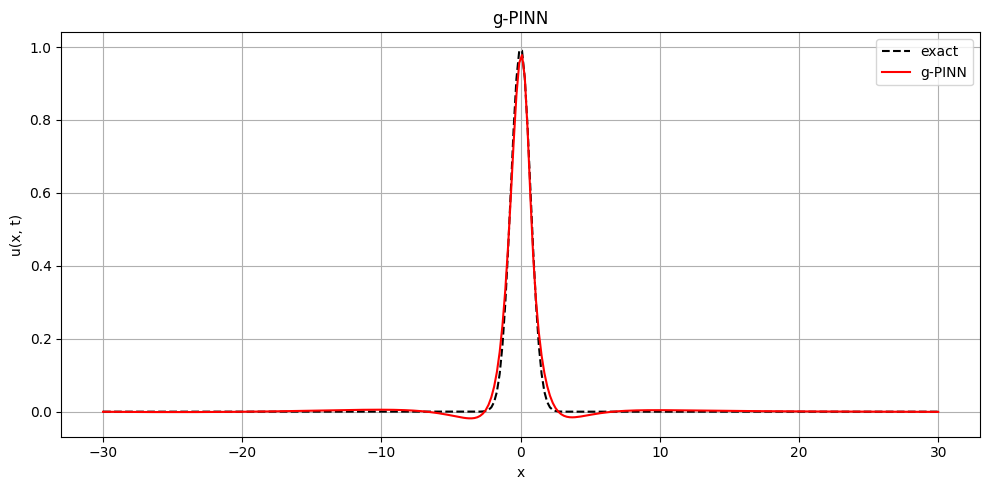

In [ ]:
# Evaluation and plot
x_test = np.linspace(X_MIN, X_MAX, 300).reshape(-1, 1)
t_zero = np.zeros_like(x_test)
t_final = np.full_like(x_test, T_MAX)
XT_test0 = tf.constant(np.hstack([x_test, t_zero]), dtype=tf.float32)
XT_test1 = tf.constant(np.hstack([x_test, t_final]), dtype=tf.float32)
u_pred0 = model(XT_test0)
u_pred1 = model(XT_test1)

plt.figure(figsize=(10, 5))
plt.plot(x_test, u_init(x_test), 'k--', label='exact')
plt.plot(x_test, u_pred0, 'r', label='g-PINN')
plt.title("g-PINN")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
